# Exercises

There are three exercises in this notebook:

1. Use the cross-validation method to test the linear regression with different $\alpha$ values, at least three.
2. Implement a SGD method that will train the Lasso regression for 10 epochs.
3. Extend the Fisher's classifier to work with two features. Use the class as the $y$.

## 1. Cross-validation linear regression

You need to change the variable ``alpha`` to be a list of alphas. Next do a loop and finally compare the results.

In [1]:
import numpy as np

def reg_predict(inputs, w, b):
    results = []
    for inp in inputs:
        results.append(inp*w+b)
    return results

def calculate_Mean_Squared_Error(y, y_predicted):
    sum_MSE = 0
    n = len(y)
    for i in range(n):
        diff = y[i] - y_predicted[i]
        squared_diff = diff**2
        sum_MSE += squared_diff
    return sum_MSE/n

heights = np.array([188, 181, 197, 168, 167, 187, 178, 194, 140, 176, 168, 192, 173, 142, 176]).reshape(-1, 1)
weights = np.array([141, 106, 149, 59, 79, 136, 65, 136, 52, 87, 115, 140, 82, 69, 121]).reshape(-1, 1)

x = heights.reshape(15,1)
y = weights.reshape(15,1)

x = np.asmatrix(np.c_[np.ones((15,1)),x])

I = np.identity(2)
alphas = [a*0.01 for a in range(0,300)]

best_MSE = None
min_alpha = None

for alpha in alphas:
    w = np.linalg.inv(x.T*x + alpha * I)*x.T*y
    y_predicted = reg_predict(heights.flatten(), w[1].item(), w[0].item())
    MSE = calculate_Mean_Squared_Error(weights.flatten(), y_predicted)
    if best_MSE is None or best_MSE > MSE:
        best_MSE = MSE
        min_aplha = alpha

print("Mean Square Error: " , best_MSE)
print("alpha: " , min_aplha)

Mean Square Error:  372.3312921517967
alpha:  0.0


## 2. Implement based on the Ridge regression example, the Lasso regression.

Please implement the SGD method and compare the results with the sklearn Lasso regression results. 

In [2]:
import numpy as np
from sklearn.linear_model import Lasso

In [3]:
# predicted_height = slope * weight + intercept
def get_prediction(intercept, slope, weight):
    return intercept + slope * weight

def sdg(x, y, learning_rate, n_iter, k):
    intercept = 0.0
    slope = 1.0
    
    for _ in range(n_iter):
#         sum_of_squared_residuals = (height -(intercept + slope * weight))^2
#         d / d intercept sum_of_squared_residuals = -2 * (height - (intercept + slope * weight))
#         d / d slope sum_of_squared_residuals = -2 * weight * (height - (intercept + slope * weight))
        intercept_gradient = 0.0
        slope_gradient = 0.0
        for i in range(k):
            y_hat = get_prediction(intercept, slope, x[i])
            intercept_gradient += -2.0 * (y[i] - y_hat)
            slope_gradient += -2.0 * x[i] * (y[i] - y_hat)
            
        step_size_intercept = (intercept_gradient / k) * learning_rate
        step_size_slope = (slope_gradient / k) * learning_rate
        
        intercept -= step_size_intercept
        slope -= step_size_slope
    
    return slope.item(), intercept.item()

In [4]:
heights = np.array([188, 181, 197, 168, 167, 187, 178, 194, 140, 176, 168, 192, 173, 142, 176]).reshape(-1, 1)
weights = np.array([141, 106, 149,  59,  79, 136,  65, 136,  52,  87, 115, 140,  82,  69, 121]).reshape(-1, 1)

slope, intercept =  sdg(heights, weights, learning_rate=0.0001, n_iter=10, k=15)
print("sdg: ", slope, intercept)

lasso_regression = Lasso(alpha=0.1)
lasso_regression.fit(X=heights, y=weights)
print("lasso regression: ", lasso_regression.coef_.item(), lasso_regression.intercept_.item())

sdg:  5730463.985809517 32440.386667402363
lasso regression:  1.6177649901016677 -180.85790859980537


## 3. Extend the Fisher's classifier

Please extend the targets of the ``iris_data`` variable and use it as the $y$.

Tutorial I've used:
[Using Linear Discriminant Analysis (LDA) for data Explore: Step by Step.](https://www.apsl.net/blog/2017/07/18/using-linear-discriminant-analysis-lda-data-explore-step-step/)

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris

In [6]:
iris_data = load_iris()
iris_df = pd.DataFrame(iris_data.data,columns=iris_data.feature_names)

X = iris_df.values
y = iris_data.target

# mean vectors of the 3 different flower classes {0, 1, 2}
mean_vectors = []
for cl in range(0,3):
    mean_vectors.append(np.mean(X[y==cl], axis=0))

# overall mean
overall_mean = np.mean(X, axis=0)
    
# within-class scatter matrix S_W
S_W = np.zeros((4,4))
for cl,mv in zip(range(0,3), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices

# between-class scatter matrix S_B
S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i,:].shape[0]
    mean_vec = mean_vec.reshape(4,1)                # make column vector
    overall_mean = overall_mean.reshape(4,1)        # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)


# generalized eigenvalue problem for the matrix (S_W)^(-1)(S_B)  to obtain the linear discriminants
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
    
# list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# matrix W
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

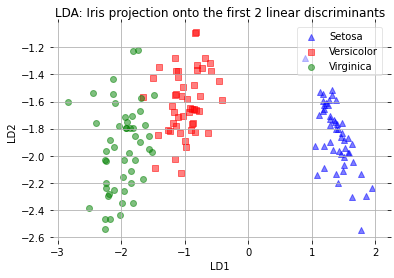

In [7]:
label_dict = {0: 'Setosa', 1: 'Versicolor', 2:'Virginica'}

X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

ax = plt.subplot(111)
for label,marker,color in zip(
    range(0,3),('^', 's', 'o'),('blue', 'red', 'green')):

    plt.scatter(x=X_lda[:,0].real[y == label],
            y=X_lda[:,1].real[y == label],
            marker=marker,
            color=color,
            alpha=0.5,
            label=label_dict[label]
            )

plt.xlabel('LD1')
plt.ylabel('LD2')

leg = plt.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.title('LDA: Iris projection onto the first 2 linear discriminants')

# hide axis ticks
plt.tick_params(axis="both", which="both", bottom="off", top="off",  
        labelbottom="on", left="off", right="off", labelleft="on")

# remove axis spines
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)    

plt.grid()
plt.tight_layout
plt.show()